In [31]:
import os
import torch
from pathlib import Path
import mediapy
import matplotlib
from typing import Tuple, Optional, List, Dict, Any, Union
# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

from pygpudrive.env.config import EnvConfig, RenderConfig, SceneConfig
from pygpudrive.env.env_torch import GPUDriveTorchEnv

In [32]:
DYNAMICS_MODEL = "delta_local" # "delta_local" / "state" / "classic"
DATA_PATH = "data/processed/examples" # Your data path
MAX_NUM_OBJECTS = 32
NUM_ENVS = 1

# Configs
render_config = RenderConfig(draw_obj_idx=True)
scene_config = SceneConfig(path=DATA_PATH, num_scenes=NUM_ENVS)
env_config = EnvConfig(dynamics_model=DYNAMICS_MODEL)

### Questions:

- What is a good balance between the number of road points and the road reduction threshold?

In [33]:
env_config.polyline_reduction_threshold = 0.01

In [34]:
env = GPUDriveTorchEnv(
    config=env_config,
    scene_config=scene_config,
    max_cont_agents=MAX_NUM_OBJECTS,
    device="cpu",
    render_config=render_config,
    action_type="continuous" # "continuous" or "discrete"
)


--- Ratio unique scenes / number of worls = 1 / 1 ---



In [35]:
from pygpudrive.datatypes.roadgraph import LocalRoadGraphPoints

local_roadgraph = LocalRoadGraphPoints.from_tensor(
    local_roadgraph_tensor=env.sim.agent_roadmap_tensor(),
    backend="torch",
    device="cpu"
)

local_roadgraph

LocalRoadGraphPoints()

In [36]:
import gpudrive

int(gpudrive.EntityType._None), int(gpudrive.EntityType.RoadEdge), 

(0, 1)

In [37]:
env.cont_agent_mask

tensor([[ True,  True, False, False, False,  True, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False]])

In [38]:
local_roadgraph.type[env.cont_agent_mask].shape

torch.Size([3, 512])

In [39]:
local_roadgraph.type[env.cont_agent_mask][0, :]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [40]:
padding_perc = (local_roadgraph.type[env.cont_agent_mask] == 0).sum()/local_roadgraph.type[env.cont_agent_mask].numel()

padding_perc

tensor(0.0462)

In [41]:
local_roadgraph.x.min(), local_roadgraph.x.max()

(tensor(-99.6710), tensor(99.6373))

In [42]:
local_roadgraph.y.min(), local_roadgraph.y.max()

(tensor(-98.2944), tensor(98.6377))

In [43]:
local_roadgraph.y.min(), local_roadgraph.y.max()

(tensor(-98.2944), tensor(98.6377))

In [44]:
local_roadgraph.segment_height.max(), local_roadgraph.segment_height.min()

(tensor(1.), tensor(0.))

In [45]:
local_roadgraph.segment_width.max(), local_roadgraph.segment_width.min()

(tensor(1.8988), tensor(0.))

In [46]:
local_roadgraph.segment_length.max(), local_roadgraph.segment_length.min()

(tensor(17.7650), tensor(0.))

### Check agent observation

In [47]:
%load_ext autoreload
%autoreload 2

from pygpudrive.visualize.core import plot_agent_observation
from pygpudrive.datatypes.observation import (
    LocalEgoState,
    PartnerObs,
    LidarObs,
)
from pygpudrive.datatypes.trajectory import LogTrajectory
from pygpudrive.datatypes.roadgraph import LocalRoadGraphPoints


In [48]:
ego_state = LocalEgoState.from_tensor(
    self_obs_tensor=env.sim.self_observation_tensor(),
    backend="torch",
    device="cpu",
)

local_roadgraph = LocalRoadGraphPoints.from_tensor(
    local_roadgraph_tensor=env.sim.agent_roadmap_tensor(),
    backend="torch",
    device="cpu",
)

partner_obs = PartnerObs.from_tensor(
    partner_obs_tensor=env.sim.partner_observations_tensor(),
    backend="torch",
    device="cpu"
)

partner_obs.rel_pos_x.shape

torch.Size([1, 32, 31, 1])

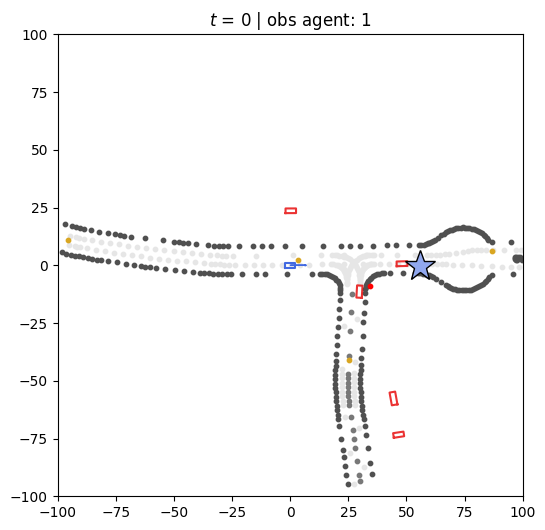

In [49]:
fig, ax = plot_agent_observation(
    env_idx=0,
    agent_idx=1,
    observation_roadgraph=local_roadgraph,
    observation_ego=ego_state,
    observation_partner=partner_obs,
    time_step=0,
);

### Check LiDAR observations

- Normalize 
- Check obs dim

In [46]:
env.reset();

In [42]:
lidar = env.sim.lidar_tensor().to_torch()

lidar.shape

torch.Size([1, 32, 3, 50, 4])

In [43]:
lidar[env.cont_agent_mask].shape

torch.Size([3, 3, 50, 4])

In [45]:
lidar[env.cont_agent_mask].max(), lidar[env.cont_agent_mask].min()

(tensor(3.2548e+33), tensor(-2.5835e+14))

In [13]:
lidar = LidarObs.from_tensor(
    lidar_tensor=env.sim.lidar_tensor(),
    backend='torch'
)

In [14]:
lidar.agent_samples.shape

torch.Size([1, 32, 50, 4])

In [15]:
lidar.road_edge_samples.shape

torch.Size([1, 32, 50, 4])

In [ ]:
lidar.road_line_samples.shape

torch.Size([1, 32, 50, 4])

In [26]:
lidar_all = torch.cat(
    [
        lidar.agent_samples,
        lidar.road_edge_samples,
        lidar.road_line_samples,
    ],
    dim=-1,
).flatten(start_dim=2)

lidar_all[env.cont_agent_mask, :].shape

torch.Size([3, 600])

In [27]:
lidar_all.shape

torch.Size([1, 32, 600])

In [29]:
lidar_all[env.cont_agent_mask, :].max(), lidar_all[env.cont_agent_mask, :].min()

(tensor(3.2548e+33), tensor(-2.5835e+14))

In [33]:
lidar.agent_samples[env.cont_agent_mask].max(), lidar.agent_samples[env.cont_agent_mask].min()


(tensor(3.2548e+33), tensor(-2.5835e+14))

In [35]:
lidar.road_edge_samples[env.cont_agent_mask].max(), lidar.road_edge_samples[env.cont_agent_mask].min()

(tensor(4.8408e+30), tensor(-2.5835e+14))

In [31]:
lidar.road_line_samples.max(), lidar.road_line_samples.min()


(tensor(7.2335e+10), tensor(-2.5835e+14))

In [32]:
lidar.shape

torch.Size([1, 32, 3, 50, 4])

In [24]:
lidar.agent_samples

tensor([[[[ 7.2349e+10,  4.5811e-41,  7.2349e+10,  4.5811e-41],
          [-2.5771e+14,  3.0662e-41, -2.5771e+14,  3.0662e-41],
          [-2.5835e+14,  3.0662e-41, -2.5771e+14,  3.0662e-41],
          ...,
          [ 4.3409e-41,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  4.6243e-44,  0.0000e+00]],

         [[-2.5774e+14,  3.0662e-41,  0.0000e+00,  0.0000e+00],
          [ 6.7359e-40,  0.0000e+00,  1.1210e-43,  0.0000e+00],
          [-2.5471e+14,  3.0662e-41,  0.0000e+00,  0.0000e+00],
          ...,
          [ 4.3051e-41,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 6.7466e-40,  0.0000e+00,  1.1210e-43,  0.0000e+00]],

         [[ 0.0000e+00,  0.0000e+00,  4.6243e-44,  0.0000e+00],
          [-2.2988e+13,  3.0662e-41, -2.5475e+14,  3.0662e-41],
          [ 6.7697e-40,  0.0000e+00,  1.1210e-43,  0.0000e+00],
      